<a href="https://colab.research.google.com/github/yoyocookie/airbnb_analysis/blob/main/airbnb_train_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.display import HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# !pip uninstall catboost
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import dcg_score
from sklearn.impute import KNNImputer
!pip install --pre h2o
os.getcwd()
from google.colab import drive
# 掛載 Google Drive
drive.mount('/content/drive')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=2061b2e9015b11f40a15ab03cb08a97a01e3ba3e9a119f6a9c455f37000d6bf4
  Stored in directory: /root/.cache/pip/wheels/62/f9/aa/687bd54342d2981bc78e22ee9b9bc39f92006e344e7aa1e0ac
Successfully built h2o
Mounted at /content/drive


#load data

In [2]:
# 從 Google Drive 載入 CSV
X_train = pd.read_csv('/content/drive/MyDrive/kaggle/X_train.csv', index_col=0)
X_val = pd.read_csv('/content/drive/MyDrive/kaggle/X_val.csv', index_col=0)
y_train = pd.read_csv('/content/drive/MyDrive/kaggle/y_train.csv', index_col=0)
y_val = pd.read_csv('/content/drive/MyDrive/kaggle/y_val.csv', index_col=0)
df_all = pd.read_csv('/content/drive/MyDrive/kaggle/data.csv')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# 將檔案存放於 /MyDrive/kaggle/kaggle.json
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c airbnb-recruiting-new-user-bookings
!unzip airbnb-recruiting-new-user-bookings.zip
!unzip '*.csv.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  airbnb-recruiting-new-user-bookings.zip
  inflating: age_gender_bkts.csv.zip  
  inflating: countries.csv.zip       
  inflating: sample_submission_NDF.csv.zip  
  inflating: sessions.csv.zip        
  inflating: test_users.csv.zip      
  inflating: train_users_2.csv.zip   
Archive:  sessions.csv.zip
  inflating: sessions.csv            

Archive:  countries.csv.zip
  inflating: countries.csv           

Archive:  age_gender_bkts.csv.zip
  inflating: age_gender_bkts.csv     

Archive:  sample_submission_NDF.csv.zip
  inflating: sample_submission_NDF.csv  

Archive:  test_users.csv.zip
  inflating: test_users.csv          

Archive:  train_users_2.csv.zip
  inflating: train_users_2.csv       

6 archives were successfully processed.


In [4]:
train = pd.read_csv('./train_users_2.csv')
test = pd.read_csv('./test_users.csv')
df_test = df_all[train.shape[0]:]

In [ ]:
import numpy as np
from sklearn.metrics import make_scorer

# 定義 NDCG@k 計算函數
def ndcg_at_k(y_true, y_pred_proba, k=5, classes=None):
    """
    計算 NDCG@k
    :param y_true: 真實的標籤 (正確的國家)，例如 ["FR", "US", ...]
    :param y_pred_proba: 預測的機率分佈，形狀 (n_samples, n_classes)
    :param k: 前 k 預測
    :param classes: 各類別標籤列表，應與模型的 classes_ 相同
    :return: NDCG@k 分數
    """
    def dcg_at_k(relevances, k):
        relevances = np.array(relevances)[:k]
        discounts = np.log2(np.arange(2, len(relevances) + 2))
        return np.sum(relevances / discounts)

    # 根據預測機率排序，取前 k 個類別索引
    y_pred_indices = np.argsort(y_pred_proba, axis=1)[:, ::-1][:, :k]

    # 轉換索引為標籤
    if classes is None:
        raise ValueError("必須提供 classes 參數 (例如 estimator.classes_)")
    # 將每個樣本的前 k 個索引轉換為標籤
    y_pred_labels = np.array([[classes[idx] for idx in sample] for sample in y_pred_indices])

    y_true = np.array(y_true)
    scores = []
    for i in range(len(y_true)):
        top_k_labels = y_pred_labels[i]
        # 如果預測的標籤與真實標籤相符則 relevance=1，否則為 0
        relevance = [1 if label == y_true[i] else 0 for label in top_k_labels]
        dcg = dcg_at_k(relevance, k)
        # 理想情況下，正確標籤應該排在第一位
        idcg = dcg_at_k([1] + [0] * (k - 1), k)
        scores.append(dcg / idcg if idcg > 0 else 0.0)

    return np.mean(scores)

# 包裝成 sklearn scorer
def ndcg_scorer_sklearn(estimator, X, y):
    """
    sklearn 格式的 NDCG scorer
    :param estimator: 模型
    :param X: 特徵
    :param y: 標籤 (例如 ["FR", "US", ...])
    """
    y_pred_proba = estimator.predict_proba(X)
    return ndcg_at_k(y, y_pred_proba, k=5, classes=estimator.classes_)



# 嘗試三種方法調參，最終使用Bayesian
1. 未調參數 0.8256
2. random 0.82577
3. grid 0.82573
4. Bayesian 0.82620


貝氏

In [5]:
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

In [ ]:
category_features = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'dac_year',
    'dac_month',
    'tfa_year',
    'tfa_month'
]

# 定義一個目標函數，利用交叉驗證計算 NDCG@5 平均分數
def catboost_cv(learning_rate, l2_leaf_reg, depth, bagging_temperature):
    # 將 depth 轉換為 int 型別
    depth = int(round(depth))

    # 建立 CatBoostClassifier，固定部分參數與超參數來自 Bayesian Optimization
    model = CatBoostClassifier(
        iterations=1000,
        loss_function='MultiClass',
        cat_features=category_features,
        task_type="GPU",      # 若電腦沒有 GPU，可改為 "CPU"
        devices="0",
        verbose=1,
        learning_rate=learning_rate,
        l2_leaf_reg=l2_leaf_reg,
        depth=depth,
        bagging_temperature=bagging_temperature
    )

    # 使用 3 折交叉驗證，採用你定義的 ndcg_scorer_sklearn 作為評分標準
    cv_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=ndcg_scorer_sklearn)

    # 由於 BayesianOptimization 預設為求最大值，因此回傳平均分數
    return np.mean(cv_scores)

# 設定 Bayesian Optimization 的搜尋空間
pbounds = {
    'learning_rate': (0.01, 0.3),
    'l2_leaf_reg': (1, 100),
    'depth': (3, 10),  # 內部會轉換為整數
    'bagging_temperature': (0, 1.2)
}

# 建立 BayesianOptimization 物件
optimizer = BayesianOptimization(
    f=catboost_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# 執行優化：init_points 為初始隨機探索次數，n_iter 為後續優化次數
optimizer.maximize(init_points=5, n_iter=20)

# 顯示最佳參數與最佳分數
print("Best parameters found:", optimizer.max)

串流輸出內容已截斷至最後 5000 行。
4:	learn: 1.9288346	total: 566ms	remaining: 1m 52s
5:	learn: 1.8637390	total: 659ms	remaining: 1m 49s
6:	learn: 1.8025705	total: 766ms	remaining: 1m 48s
7:	learn: 1.7515305	total: 912ms	remaining: 1m 53s
8:	learn: 1.7043943	total: 1.07s	remaining: 1m 57s
9:	learn: 1.6631510	total: 1.24s	remaining: 2m 2s
10:	learn: 1.6255610	total: 1.41s	remaining: 2m 6s
11:	learn: 1.5905529	total: 1.61s	remaining: 2m 12s
12:	learn: 1.5581567	total: 1.72s	remaining: 2m 10s
13:	learn: 1.5281422	total: 1.89s	remaining: 2m 13s
14:	learn: 1.5010916	total: 2.04s	remaining: 2m 14s
15:	learn: 1.4742905	total: 2.22s	remaining: 2m 16s
16:	learn: 1.4497886	total: 2.38s	remaining: 2m 17s
17:	learn: 1.4273778	total: 2.56s	remaining: 2m 19s
18:	learn: 1.4067677	total: 2.73s	remaining: 2m 21s
19:	learn: 1.3878477	total: 2.93s	remaining: 2m 23s
20:	learn: 1.3702248	total: 3.09s	remaining: 2m 24s
21:	learn: 1.3536337	total: 3.28s	remaining: 2m 26s
22:	learn: 1.3381182	total: 3.46s	remaining: 2m 27s

Best parameters found: {'target': 0.8267315710920776, 'params': {'bagging_temperature': 0.8682581915606292, 'depth': 5.77666016949477, 'l2_leaf_reg': 36.748870377605314, 'learning_rate': 0.028446198513218696}}

In [6]:
category_features = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'dac_year',
    'dac_month',
    'tfa_year',
    'tfa_month'
]

model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.02845,
    l2_leaf_reg=36.75,
    depth=6,
    border_count=64,
    bagging_temperature=0.86826,
    loss_function='MultiClass',
    cat_features=category_features,
    task_type="GPU",  # 啟用 GPU
    devices="0",       # 使用第 0 張 GPU
    verbose=0
)

# 訓練模型
model.fit(X_train, y_train, cat_features=category_features)

In [ ]:
# 保存原始的 id 欄位
test_ids = df_test['id']

# 移除 id 欄位
df_test = df_test.drop(columns=['id','date_account_created','timestamp_first_active'])

# 預測 df_test 的結果
predictions = model.predict_proba(df_test)

In [ ]:
# 獲取國家目的地的名稱
classes = model.classes_

# 創建 DataFrame 以存儲結果
result_list = []

for i, probs in enumerate(predictions):
    # 獲取前五高的機率索引
    top5_indices = probs.argsort()[-5:][::-1]
    # 獲取對應的國家名稱和機率
    top5_countries = classes[top5_indices]
    top5_probs = probs[top5_indices]
    # 組合結果
    for country, prob in zip(top5_countries, top5_probs):
        result_list.append({'id': test_ids.iloc[i], 'country': country, 'probability': prob})


In [ ]:
# 轉換為 DataFrame 並按需要排序
result_df = pd.DataFrame(result_list)

result_df.drop(columns=['probability'], inplace=True)

In [ ]:
# result_df.to_csv('/content/drive/MyDrive/kaggle/submission.csv', index=False)

In [ ]:
# !kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f /content/drive/MyDrive/kaggle/submission.csv -m 'test submission'

In [ ]:
# #查詢結果
# !kaggle competitions submissions airbnb-recruiting-new-user-bookings
# #查詢Leaderboard
# # !kaggle competitions leaderboard airbnb-recruiting-new-user-bookings -s

In [ ]:
# #查詢Leaderboard
# !kaggle competitions leaderboard airbnb-recruiting-new-user-bookings -s

In [ ]:
# 假設 X_val 為驗證集的特徵，y_val 為驗證集的真實標籤（例如 "FR", "US", ...）
y_pred_proba = model.predict_proba(X_val)  # 得到形狀為 (n_samples, n_classes) 的預測機率矩陣

# 計算 NDCG@5 分數，並傳入模型的類別標籤
ndcg_score = ndcg_at_k(y_val, y_pred_proba, k=5, classes=model.classes_)

print("NDCG@5 score:", ndcg_score)


NDCG@5 score: 0.8262021800307524


In [7]:
from sklearn.preprocessing import LabelEncoder
def frequency_encoding(train_df, valid_df, cat_cols):
    """
    對給定的類別特徵進行 Frequency Encoding。

    :param train_df: 訓練資料的 DataFrame
    :param valid_df: 驗證資料的 DataFrame
    :param cat_cols: 要編碼的類別特徵名稱列表
    :return: 編碼後的訓練與驗證資料（原始特徵不會被移除，但新增了 _freq 後綴的欄位）
    """
    for col in cat_cols:
        # 使用 normalized frequency，即每個值出現的比例
        freq_encoding = train_df[col].value_counts(normalize=True)
        # 將頻率映射到新欄位
        train_df[col + '_freq'] = train_df[col].map(freq_encoding)
        valid_df[col + '_freq'] = valid_df[col].map(freq_encoding)
        # 若驗證集中有訓練集中沒有出現的值，填補 0
        valid_df[col + '_freq'] = valid_df[col + '_freq'].fillna(0)
    return train_df, valid_df


category_features = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'dac_year',
    'dac_month',
    'tfa_year',
    'tfa_month'
]

# 假設 X_train 與 X_val 已經是 DataFrame 並包含這些類別特徵
X_train_encoded, X_val_encoded = frequency_encoding(X_train.copy(), X_val.copy(), category_features)

X_train_encoded = X_train_encoded.drop(columns=category_features)
X_val_encoded = X_val_encoded.drop(columns=category_features)



In [8]:
!pip install --upgrade xgboost scikit-learn
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
from re import VERBOSE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# 先對目標標籤進行編碼
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train.copy())
y_val_encoded = le.transform(y_val.copy())

# 建立 XGBoost 模型 (多分類)
model_xgb = XGBClassifier(
    objective='multi:softprob',  # 多分類（返回每個類別的機率）
    eval_metric='mlogloss',    # 多分類 logloss 指標
    tree_method = "hist",    # 使用 GPU 加速的訓練方法
    device = "cuda",
    random_state=42        # 固定隨機種子
)
from sklearn import set_config
set_config(display="text")
# 訓練模型（使用 Frequency Encoding 後的特徵）
model_xgb.fit(X_train_encoded, y_train_encoded)

# 預測驗證集
y_pred = model_xgb.predict(X_val_encoded)
y_pred_proba = model_xgb.predict_proba(X_val_encoded)

# 計算驗證集準確率
accuracy = accuracy_score(y_val_encoded, y_pred)
print("XGBoost Validation Accuracy: {:.4f}".format(accuracy))

# 如果需要將預測的數值轉回原始標籤，可以用：
y_pred_labels = le.inverse_transform(y_pred)
print("Some predicted labels:", y_pred_labels[:10])


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


XGBoost Validation Accuracy: 0.6362
Some predicted labels: ['NDF' 'NDF' 'NDF' 'NDF' 'IT' 'NDF' 'US' 'NDF' 'US' 'US']


In [ ]:
from xgboost import XGBClassifier

# 預測機率分佈
y_pred_proba = model_xgb.predict_proba(X_val_encoded)
classes = model_xgb.classes_  # 獲取模型的分類標籤

# 計算 NDCG@k 分數
k = 5
ndcg_score = ndcg_at_k(y_true=y_val_encoded, y_pred_proba=y_pred_proba, k=k, classes=classes)

print(f"NDCG@{k} Score: {ndcg_score:.4f}")


NDCG@5 Score: 0.8247


# XGboost bayesian調參數

In [ ]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

# 假設 X_train, y_train 為你的訓練資料 (pandas DataFrame/Series)
# 以及已定義好 ndcg_scorer_sklearn 函數

def xgboost_cv(learning_rate, max_depth, min_child_weight, subsample, colsample_bytree):
    # 將 max_depth 轉換為整數
    max_depth = int(round(max_depth))

    # 建立 XGBClassifier 模型
    model = XGBClassifier(
        objective='multi:softprob',       # 多分類，返回每個類別的機率
        eval_metric='mlogloss',             # 使用多分類的 logloss 指標
        random_state=42,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        tree_method = "hist",
        device = "cuda"
    )

    # 使用 3 折交叉驗證，並以自訂的 NDCG@5 scorer 來計算平均分數
    cv_scores = cross_val_score(model, X_train_encoded, y_train_encoded, cv=3, scoring=ndcg_scorer_sklearn)

    # BayesianOptimization 預設是求最大值，因此回傳平均 NDCG 分數
    return np.mean(cv_scores)

# 定義 XGBoost 超參數的搜尋空間
pbounds = {
    'learning_rate': (0.01, 0.3),
    'max_depth': (3, 10),            # 內部轉換為整數
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# 建立 BayesianOptimization 物件
optimizer = BayesianOptimization(
    f=xgboost_cv,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# 執行優化
optimizer.maximize(init_points=5, n_iter=20)

# 顯示最佳參數與最佳分數
print("Best parameters found:", optimizer.max)


|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.8213    | 0.6873    | 0.2857    | 8.124     | 6.388     | 0.578     |
| 2         | 0.8255    | 0.578     | 0.02684   | 9.063     | 6.41      | 0.854     |
| 3         | 0.8196    | 0.5103    | 0.2913    | 8.827     | 2.911     | 0.5909    |
| 4         | 0.826     | 0.5917    | 0.09823   | 6.673     | 4.888     | 0.6456    |
| 5         | 0.8262    | 0.8059    | 0.05045   | 5.045     | 4.297     | 0.728     |
| 6         | 0.8263    | 0.783     | 0.09715   | 5.066     | 4.25      | 0.8113    |
| 7         | 0.8261    | 0.8122    | 0.02836   | 6.141     | 3.708     | 0.5855    |
| 8         | 0.8227    | 0.7731    | 0.1674    | 9.988     | 7.209     | 0.8558    |
| 9         | 0.8254    | 0.52      | 0.2016    | 5.694     | 5.173     | 0.9906    |
| 10        | 0.8252    | 0.5952    | 0.02782   | 4.86

In [10]:
# 先對目標標籤進行編碼
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train.copy())
y_val_encoded = le.transform(y_val.copy())

# 建立 XGBoost 模型 (多分類)
model_xgb = XGBClassifier(
    objective='multi:softprob',  # 多分類（返回每個類別的機率）
    eval_metric='mlogloss', # 多分類 logloss 指標
    tree_method = "hist",
    device = "cuda",  # 使用 GPU 進行預測
    colsample_bytree = 0.7830,
    learning_rate = 0.0972,
    max_depth = 5,
    min_child_weight = 4,
    subsample = 0.8,
    random_state=42        # 固定隨機種子
)
from sklearn import set_config
set_config(display="text")
# 訓練模型（使用 Frequency Encoding 後的特徵）
model_xgb.fit(X_train_encoded, y_train_encoded)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.783, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0972, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
from xgboost import XGBClassifier

# 預測機率分佈
y_pred_proba = model_xgb.predict_proba(X_val_encoded)
classes = model_xgb.classes_  # 獲取模型的分類標籤

# 計算 NDCG@k 分數
k = 5
ndcg_score = ndcg_at_k(y_true=y_val_encoded, y_pred_proba=y_pred_proba, k=k, classes=classes)

print(f"NDCG@{k} Score: {ndcg_score:.4f}")


NDCG@5 Score: 0.8257


In [ ]:
# 從 Google Drive 載入 CSV
X_train = pd.read_csv('/content/drive/MyDrive/kaggle/X_train.csv', index_col=0)
X_val = pd.read_csv('/content/drive/MyDrive/kaggle/X_val.csv', index_col=0)
y_train = pd.read_csv('/content/drive/MyDrive/kaggle/y_train.csv', index_col=0)
y_val = pd.read_csv('/content/drive/MyDrive/kaggle/y_val.csv', index_col=0)
df_all = pd.read_csv('/content/drive/MyDrive/kaggle/data.csv')

train = pd.read_csv('./train_users_2.csv')
test = pd.read_csv('./test_users.csv')
df_test = df_all[train.shape[0]:]
df_train = df_all[:train.shape[0]]

In [ ]:
# 保存原始的 id 欄位
test_ids = df_test['id']

# 移除 id 欄位
df_test = df_test.drop(columns=['id','date_account_created','timestamp_first_active'])
df_train = df_train.drop(columns=['id','date_account_created','timestamp_first_active'])


In [ ]:
df_train_encoded, df_test_encoded = frequency_encoding(df_train.copy(), df_test.copy(), category_features)

df_train_encoded = df_train_encoded.drop(columns=category_features)
df_test_encoded = df_test_encoded.drop(columns=category_features)

# 預測 df_test 的結果
predictions = model_xgb.predict_proba(df_test_encoded)

In [ ]:
# 獲取國家目的地的名稱
classes = model.classes_

# 創建 DataFrame 以存儲結果
result_list = []

for i, probs in enumerate(predictions):
    # 獲取前五高的機率索引
    top5_indices = probs.argsort()[-5:][::-1]
    # 獲取對應的國家名稱和機率
    top5_countries = classes[top5_indices]
    top5_probs = probs[top5_indices]
    # 組合結果
    for country, prob in zip(top5_countries, top5_probs):
        result_list.append({'id': test_ids.iloc[i], 'country': country, 'probability': prob})


In [ ]:
# 轉換為 DataFrame 並按需要排序
result_df = pd.DataFrame(result_list)

result_df.drop(columns=['probability'], inplace=True)

In [ ]:
result_df.to_csv('/content/drive/MyDrive/kaggle/xgboost1.csv', index=False)

In [ ]:
!kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f /content/drive/MyDrive/kaggle/xgboost1.csv -m 'xgboost look this'

100% 4.38M/4.38M [00:00<00:00, 6.21MB/s]
Successfully submitted to Airbnb New User Bookings

# H2O 實現 AutoML

In [ ]:
# # 從 Google Drive 載入 CSV
# X_train = pd.read_csv('/content/drive/MyDrive/kaggle/X_train.csv', index_col=0)
# X_val = pd.read_csv('/content/drive/MyDrive/kaggle/X_val.csv', index_col=0)
# y_train = pd.read_csv('/content/drive/MyDrive/kaggle/y_train.csv', index_col=0)
# y_val = pd.read_csv('/content/drive/MyDrive/kaggle/y_val.csv', index_col=0)

In [ ]:
import h2o
from h2o.automl import H2OAutoML
# 引入 H2O 的 TargetEncoder 估計器
from h2o.estimators.targetencoder import H2OTargetEncoderEstimator

# 1. 初始化 H2O 集群
h2o.init()

# 2. 載入資料
X_train = h2o.import_file('/content/drive/MyDrive/kaggle/X_train.csv')
X_val   = h2o.import_file('/content/drive/MyDrive/kaggle/X_val.csv')
y_train = h2o.import_file('/content/drive/MyDrive/kaggle/y_train.csv')
y_val   = h2o.import_file('/content/drive/MyDrive/kaggle/y_val.csv')

# 3. 合併特徵與目標變數
train = X_train.cbind(y_train)
val   = X_val.cbind(y_val)

# 4. 設定目標變數名稱
target = "country_destination"

# 5. 將目標變數轉為 factor（分類問題需要）
train[target] = train[target].asfactor()
val[target]   = val[target].asfactor()

# 6. 將以數字表示但實際上代表類別的變數轉換為 factor
category_features = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'dac_year',
    'dac_month',
    'tfa_year',
    'tfa_month'
]
for col in category_features:
    train[col] = train[col].asfactor()
    val[col]   = val[col].asfactor()

# 7. 使用 H2O Target Encoder 對類別變數進行 target encoding
te_model = H2OTargetEncoderEstimator()
te_model.train(x=category_features, y=target, training_frame=train)

# 透過 target encoder 將訓練和驗證集轉換為編碼後的資料
# 注意：holdout_type 設定為 "None" 表示不保留內部 holdout 統計，直接利用全部訓練資料計算 encoding
train_te = te_model.transform(train)
val_te   = te_model.transform(val)

# 8. 定義特徵（排除目標變數），此時資料中的 category_features 已經被轉換為數值型特徵
predictors = [col for col in train_te.col_names if col != target]

# 9. 使用 H2O AutoML 自動訓練模型（包含 XGBoost、GBM、DRF、DeepLearning 與 StackedEnsemble）
aml = H2OAutoML(max_runtime_secs=6000, seed=42, include_algos=['XGBoost', 'GBM', 'DRF', 'DeepLearning', 'StackedEnsemble'])
aml.train(x=predictors, y=target, training_frame=train_te, leaderboard_frame=val_te)

# 10. 查看排行榜，了解不同模型的表現
lb = aml.leaderboard
print(lb)

# 11. 在驗證集上進行預測
pred = aml.leader.predict(val_te)
print(pred)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpyi344buu
  JVM stdout: /tmp/tmpyi344buu/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpyi344buu/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 16 days
H2O_cluster_name:,H2O_from_python_unknownUser_pocgdq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
targetencoder Model Build progress: |████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                  mean_per_class_error    logloss      rmse       mse
StackedEnsemble_BestOfFamily_2_AutoML_1_20250318_44053                0.889093    1.05601  0.569105  0.32388
GBM_2_AutoML_1_20250318_44053                                         0.889132    1.06416  0.568135  0.322778
StackedEnsemble_AllModels_1_AutoML_1_20250318_44053                   0.889376    1.05519  0.569012  

/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'signup_flow' has levels not trained on: ["4"]
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'first_browser' has levels not trained on: ["IceDragon"]
  warnings.warn(w)


In [ ]:
import h2o
import numpy as np
import pandas as pd

# 初始化 H2O
h2o.init()

# 假設 df_test 是你的測試資料 (pandas DataFrame)
# 保存原始的 id 欄位
test_ids = df_test['id']

# 移除不需要的欄位
df_test = df_test.drop(columns=['id','date_account_created','timestamp_first_active'])

# 將 pandas 的 df_test 轉為 H2OFrame
df_test_h2o = h2o.H2OFrame(df_test)

# 使用 H2O AutoML 模型進行預測 (假設你已訓練的 AutoML 模型變數名稱為 aml)
predictions = aml.predict(df_test_h2o)

# 將預測結果轉換成 pandas DataFrame
predictions_df = predictions.as_data_frame()

# 預測結果通常第一欄為預測類別，其餘欄位為各類別的機率
# 取得機率部分與類別名稱
probabilities = predictions_df.iloc[:, 1:].values   # 所有機率數值
classes = np.array(predictions_df.columns[1:])         # 各類別名稱，轉成 numpy 陣列

# 建立結果列表，存放每筆資料的前五高預測
result_list = []

for i, probs in enumerate(probabilities):
    # 找出前五高機率的索引，從高到低排序
    top5_indices = probs.argsort()[-5:][::-1]
    # 取得對應的國家名稱和機率
    top5_countries = classes[top5_indices]
    top5_probs = probs[top5_indices]
    # 組合結果
    for country, prob in zip(top5_countries, top5_probs):
        result_list.append({'id': test_ids.iloc[i], 'country': country, 'probability': prob})

# 轉換結果為 DataFrame
result_df = pd.DataFrame(result_list)

# 顯示結果或儲存
print(result_df.head())
# result_df.to_csv('h2o_predictions.csv', index=False)


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,5 hours 7 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 16 days
H2O_cluster_name:,H2O_from_python_unknownUser_pocgdq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.662 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'C1': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'C10': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'gender_freq': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'signup_method_freq': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'signup_flow_freq': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'language_freq'

           id country  probability
0  5uwns89zht      US     0.452740
1  5uwns89zht     NDF     0.351644
2  5uwns89zht   other     0.073910
3  5uwns89zht      FR     0.037056
4  5uwns89zht      IT     0.022103


In [ ]:
import h2o
import numpy as np
import pandas as pd

# 初始化 H2O
h2o.init()

# 假設 df_test 是你的測試資料 (pandas DataFrame)
# 保存原始的 id 欄位
test_ids = df_test['id']

# 移除不需要的欄位
df_test = df_test.drop(columns=['id','date_account_created','timestamp_first_active'])

# 將 pandas 的 df_test 轉為 H2OFrame
df_test_h2o = h2o.H2OFrame(df_test)

# 使用 H2O AutoML 模型進行預測 (假設你已訓練的 AutoML 模型變數名稱為 aml)
predictions = aml.predict(df_test_h2o)

# 將預測結果轉換成 pandas DataFrame
predictions_df = predictions.as_data_frame()

# 預測結果通常第一欄為預測類別，其餘欄位為各類別的機率
# 取得機率部分與類別名稱
probabilities = predictions_df.iloc[:, 1:].values   # 所有機率數值
classes = np.array(predictions_df.columns[1:])         # 各類別名稱，轉成 numpy 陣列

# 建立結果列表，存放每筆資料的前五高預測
result_list = []

for i, probs in enumerate(probabilities):
    # 找出預測類別的索引，並取得其對應的類別名稱和機率
    predicted_class_index = np.argmax(probs)
    predicted_class = classes[predicted_class_index]
    predicted_prob = probs[predicted_class_index]

    # 排除預測的類別，找出剩下四個機率最高的類別
    remaining_indices = np.delete(np.arange(len(probs)), predicted_class_index)  # 刪除預測類別的索引
    remaining_probs = probs[remaining_indices]
    remaining_countries = classes[remaining_indices]

    # 找出剩下的四個類別，按機率從高到低排序
    top4_indices = remaining_probs.argsort()[-4:][::-1]
    top4_countries = remaining_countries[top4_indices]
    top4_probs = remaining_probs[top4_indices]

    # 將預測結果與前四個類別組合在一起
    result_list.append({'id': test_ids.iloc[i], 'country': predicted_class, 'probability': predicted_prob})
    for country, prob in zip(top4_countries, top4_probs):
        result_list.append({'id': test_ids.iloc[i], 'country': country, 'probability': prob})

# 轉換結果為 DataFrame
result_df = pd.DataFrame(result_list)

# 顯示結果或儲存
print(result_df.head())
# result_df.to_csv('h2o_predictions.csv', index=False)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,5 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 16 days
H2O_cluster_name:,H2O_from_python_unknownUser_pocgdq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.651 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'C1': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'C10': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'gender_freq': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'signup_method_freq': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'signup_flow_freq': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'language_freq'

           id country  probability
0  5uwns89zht      US     0.452740
1  5uwns89zht     NDF     0.351644
2  5uwns89zht   other     0.073910
3  5uwns89zht      FR     0.037056
4  5uwns89zht      IT     0.022103


In [ ]:
result_df.drop(columns=['probability'], inplace=True)
result_df.to_csv('/content/drive/MyDrive/kaggle/submission_H2O_5.csv', index=False)
!kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f /content/drive/MyDrive/kaggle/submission_H2O_4.csv -m 'check'


100% 4.38M/4.38M [00:01<00:00, 3.76MB/s]
Successfully submitted to Airbnb New User Bookings

In [11]:
import h2o
from h2o.automl import H2OAutoML
# 引入 H2O 的 TargetEncoder 估計器
from h2o.estimators.targetencoder import H2OTargetEncoderEstimator

# 1. 初始化 H2O 集群
h2o.init()

# 2. 載入資料
X_train = h2o.import_file('/content/drive/MyDrive/kaggle/X_train.csv')
X_val   = h2o.import_file('/content/drive/MyDrive/kaggle/X_val.csv')
y_train = h2o.import_file('/content/drive/MyDrive/kaggle/y_train.csv')
y_val   = h2o.import_file('/content/drive/MyDrive/kaggle/y_val.csv')

# 3. 合併特徵與目標變數
train = X_train.cbind(y_train)
val   = X_val.cbind(y_val)

# 4. 設定目標變數名稱
target = "country_destination"

# 5. 將目標變數轉為 factor（分類問題需要）
train[target] = train[target].asfactor()
val[target]   = val[target].asfactor()

# 6. 將以數字表示但實際上代表類別的變數轉換為 factor
category_features = [
    'gender',
    'signup_method',
    'signup_flow',
    'language',
    'affiliate_channel',
    'affiliate_provider',
    'first_affiliate_tracked',
    'signup_app',
    'first_device_type',
    'first_browser',
    'dac_year',
    'dac_month',
    'tfa_year',
    'tfa_month'
]
for col in category_features:
    train[col] = train[col].asfactor()
    val[col]   = val[col].asfactor()

# 7. 使用 H2O Target Encoder 對類別變數進行 target encoding
te_model = H2OTargetEncoderEstimator()
te_model.train(x=category_features, y=target, training_frame=train)

# 透過 target encoder 將訓練和驗證集轉換為編碼後的資料
# 注意：holdout_type 設定為 "None" 表示不保留內部 holdout 統計，直接利用全部訓練資料計算 encoding
train_te = te_model.transform(train)
val_te   = te_model.transform(val)

# 8. 定義特徵（排除目標變數），此時資料中的 category_features 已經被轉換為數值型特徵
predictors = [col for col in train_te.col_names if col != target]

# 9. 使用 H2O AutoML 自動訓練模型（包含 XGBoost、GBM、DRF、DeepLearning 與 StackedEnsemble）
aml = H2OAutoML(max_runtime_secs=10000, seed=42, stopping_rounds=5, stopping_tolerance= 0.0024, stopping_metric="logloss", include_algos=['XGBoost', 'GBM', 'DRF', 'DeepLearning', 'StackedEnsemble'])
aml.train(x=predictors, y=target, training_frame=train_te, leaderboard_frame=val_te)

# 10. 查看排行榜，了解不同模型的表現
lb = aml.leaderboard
print(lb)

# 11. 在驗證集上進行預測
pred = aml.leader.predict(val_te)
print(pred)


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmphm7yifld
  JVM stdout: /tmp/tmphm7yifld/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmphm7yifld/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 18 days
H2O_cluster_name:,H2O_from_python_unknownUser_tkytod
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
targetencoder Model Build progress: |████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
model_id                                                  mean_per_class_error    logloss      rmse       mse
StackedEnsemble_AllModels_1_AutoML_1_20250321_24400                   0.885713    1.08493  0.595991  0.355206
StackedEnsemble_BestOfFamily_1_AutoML_1_20250321_24400                0.886013    1.07539  0.587748  0.345447
StackedEnsemble_BestOfFamily_2_AutoML_1_20250321_24400                0.887676    1.06341  0.579236 

/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'signup_flow' has levels not trained on: ["4"]
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'first_browser' has levels not trained on: ["IceDragon"]
  warnings.warn(w)


In [12]:
# 儲存最佳模型
best_model = aml.leader

save_path = "/content/drive/MyDrive/kaggle/"

# 儲存模型
model_path = h2o.save_model(model=best_model, path=save_path, force=True)

# # 載入儲存的模型
# model_path = "/content/drive/MyDrive/kaggle/models/best_model.zip"
# aml_model = h2o.load_model(model_path)

In [15]:
# 從 Google Drive 載入 CSV
X_train = pd.read_csv('/content/drive/MyDrive/kaggle/X_train.csv', index_col=0)
X_val = pd.read_csv('/content/drive/MyDrive/kaggle/X_val.csv', index_col=0)
y_train = pd.read_csv('/content/drive/MyDrive/kaggle/y_train.csv', index_col=0)
y_val = pd.read_csv('/content/drive/MyDrive/kaggle/y_val.csv', index_col=0)
df_all = pd.read_csv('/content/drive/MyDrive/kaggle/data.csv')

In [16]:
train = pd.read_csv('./train_users_2.csv')
test = pd.read_csv('./test_users.csv')
df_test = df_all[train.shape[0]:]

In [ ]:
import h2o
import numpy as np
import pandas as pd

# 初始化 H2O
h2o.init()

# 假設 df_test 是你的測試資料 (pandas DataFrame)
# 保存原始的 id 欄位
test_ids = df_test['id']

# 移除不需要的欄位
df_test = df_test.drop(columns=['id','date_account_created','timestamp_first_active'])

# 將 pandas 的 df_test 轉為 H2OFrame
df_test_h2o = h2o.H2OFrame(df_test)

# 使用 H2O AutoML 模型進行預測 (假設你已訓練的 AutoML 模型變數名稱為 aml)
predictions = aml.predict(df_test_h2o)

# 將預測結果轉換成 pandas DataFrame
predictions_df = predictions.as_data_frame()

# 預測結果通常第一欄為預測類別，其餘欄位為各類別的機率
# 取得機率部分與類別名稱
probabilities = predictions_df.iloc[:, 1:].values   # 所有機率數值
classes = np.array(predictions_df.columns[1:])         # 各類別名稱，轉成 numpy 陣列

# 建立結果列表，存放每筆資料的前五高預測
result_list = []

for i, probs in enumerate(probabilities):
    # 找出預測類別的索引，並取得其對應的類別名稱和機率
    predicted_class_index = np.argmax(probs)
    predicted_class = classes[predicted_class_index]
    predicted_prob = probs[predicted_class_index]

    # 排除預測的類別，找出剩下四個機率最高的類別
    remaining_indices = np.delete(np.arange(len(probs)), predicted_class_index)  # 刪除預測類別的索引
    remaining_probs = probs[remaining_indices]
    remaining_countries = classes[remaining_indices]

    # 找出剩下的四個類別，按機率從高到低排序
    top4_indices = remaining_probs.argsort()[-4:][::-1]
    top4_countries = remaining_countries[top4_indices]
    top4_probs = remaining_probs[top4_indices]

    # 將預測結果與前四個類別組合在一起
    result_list.append({'id': test_ids.iloc[i], 'country': predicted_class, 'probability': predicted_prob})
    for country, prob in zip(top4_countries, top4_probs):
        result_list.append({'id': test_ids.iloc[i], 'country': country, 'probability': prob})

# 轉換結果為 DataFrame
result_df = pd.DataFrame(result_list)

# 顯示結果或儲存
print(result_df.head())
# result_df.to_csv('h2o_predictions.csv', index=False)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,3 hours 59 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,4 months and 17 days
H2O_cluster_name:,H2O_from_python_unknownUser_g0812h
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.179 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'gender_CA_te': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'gender_DE_te': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'gender_ES_te': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'gender_FR_te': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'gender_GB_te': substituting in a column of NaN
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset is missing column 'gend

           id country  probability
0  5uwns89zht     NDF     0.426904
1  5uwns89zht      US     0.390155
2  5uwns89zht   other     0.056053
3  5uwns89zht      FR     0.041178
4  5uwns89zht      IT     0.019506


In [ ]:
result_df.drop(columns=['probability'], inplace=True)
result_df.to_csv('/content/drive/MyDrive/kaggle/submission_H2O_7.csv', index=False)
!kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f /content/drive/MyDrive/kaggle/submission_H2O_7.csv -m 'logloss,early stop'


100% 4.38M/4.38M [00:02<00:00, 1.86MB/s]
Successfully submitted to Airbnb New User Bookings

# 模型比較


In [17]:
y_val

,country_destination
13171,NDF
56632,NDF
193121,NDF
136288,NDF
111001,IT
...,...
57745,NDF
105579,NDF
13571,NDF
185459,NDF


stackedensemble prediction progress: |

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:04:37] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  msg += " or "


███████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'signup_flow' has levels not trained on: ["4"]
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'first_browser' has levels not trained on: ["IceDragon"]
  warnings.warn(w)
/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


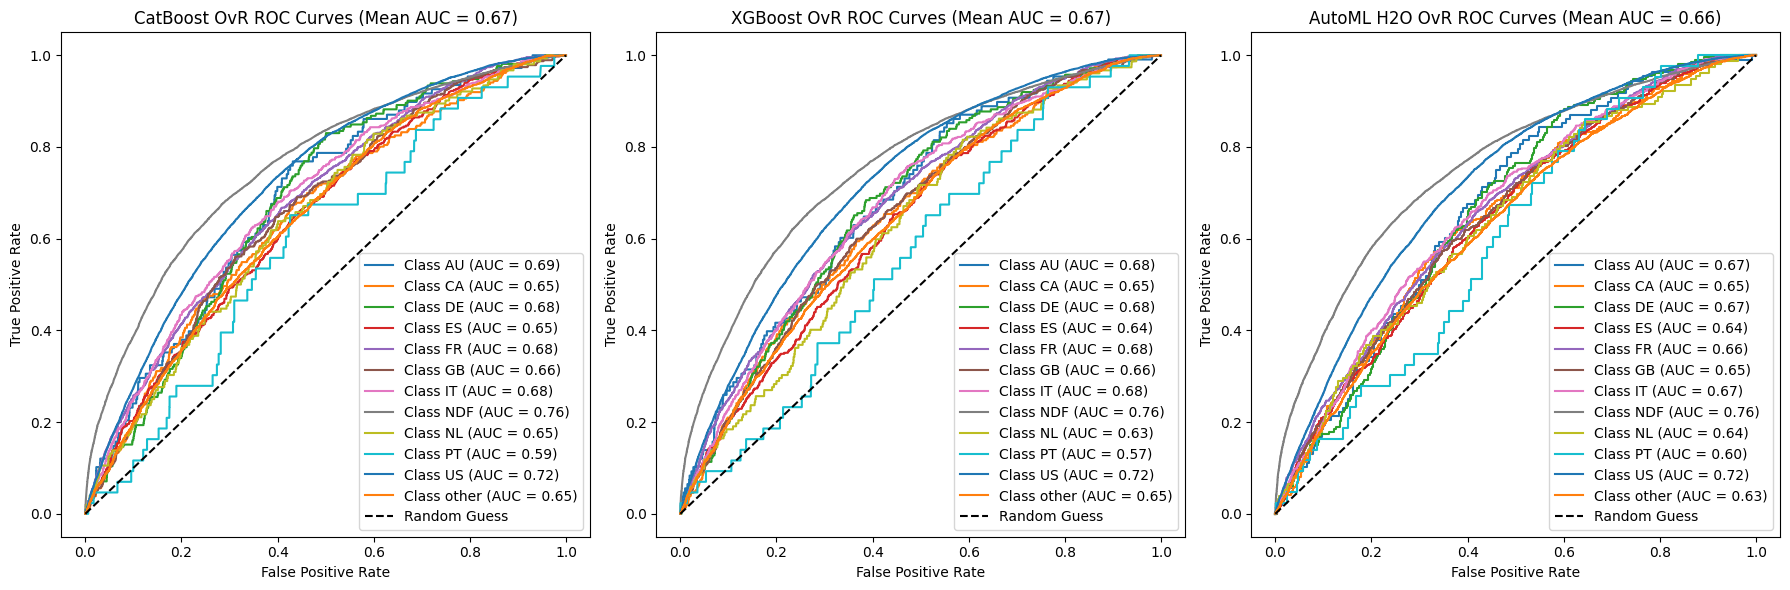

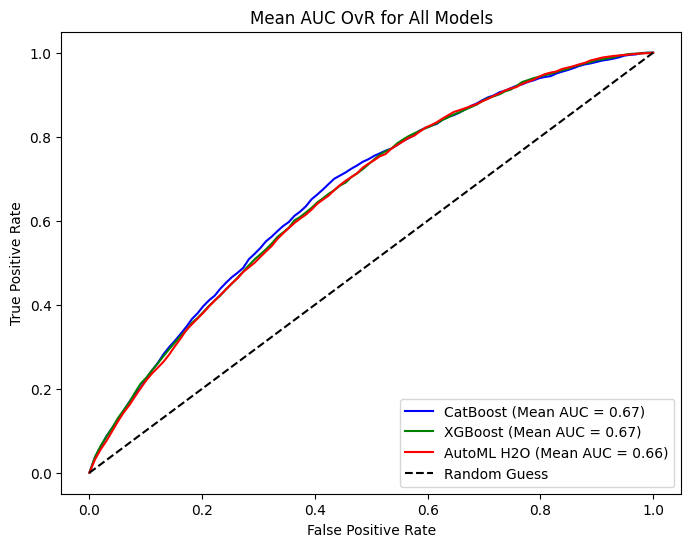

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# 假設你的資料類別數量
classes = np.unique(y_val)
n_classes = len(classes)

# One-vs-Rest ROC 繪製函式
def plot_roc_ovr(y_true, y_pred_proba, model_name, ax):
    y_true_bin = label_binarize(y_true, classes=classes)
    mean_fpr = np.linspace(0, 1, 100)
    aucs = []

    # 繪製每個類別的 ROC 曲線
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, label=f'Class {classes[i]} (AUC = {roc_auc:.2f})')

    # 平均 AUC
    mean_auc = np.mean(aucs)
    ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    ax.set_title(f"{model_name} OvR ROC Curves (Mean AUC = {mean_auc:.2f})")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    return mean_auc

# 模型預測（假設已經有各模型對驗證集的概率預測）
y_val = y_val.values.ravel()  # Flatten y_val
probas_catboost = model.predict_proba(X_val)       # CatBoost 機率預測
probas_xgboost = model_xgb.predict_proba(X_val_encoded)  # XGBoost 機率預測
probas_automl = aml.leader.predict(val_te).as_data_frame().iloc[:, 1:].values  # H2O AutoML 預測

# 畫三張圖（每模型一張）
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

mean_auc_catboost = plot_roc_ovr(y_val, probas_catboost, "CatBoost", axs[0])
mean_auc_xgboost = plot_roc_ovr(y_val, probas_xgboost, "XGBoost", axs[1])
mean_auc_automl = plot_roc_ovr(y_val, probas_automl, "AutoML H2O", axs[2])

plt.tight_layout()
plt.show()

# 繪製第四張圖（每模型一條平均 AUC 線）
plt.figure(figsize=(8, 6))
mean_fpr = np.linspace(0, 1, 100)

# 平均 AUC 曲線
for probas, model_name, color in zip(
    [probas_catboost, probas_xgboost, probas_automl],
    ["CatBoost", "XGBoost", "AutoML H2O"],
    ['blue', 'green', 'red']
):
    y_true_bin = label_binarize(y_val, classes=classes)
    mean_tpr = np.zeros_like(mean_fpr)
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], probas[:, i])
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= n_classes
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, label=f"{model_name} (Mean AUC = {mean_auc:.2f})", color=color)

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Mean AUC OvR for All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()
